# What temperature are the spots of TRAPPIST-1?

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os
from scipy.optimize import fmin_powell

import sys
sys.path.insert(0, '../')

In [41]:
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']
phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')


bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

# plt.plot(kplr_wavelength, kplr_trans)
# plt.plot(phoenix_wavelength, phoenix_flux)
# trappist_flux = phoenix_flux * bb_2559.value/bb_2600.value
# plt.plot(phoenix_wavelength, trappist_flux)
# plt.xlim([200, 1000])

([], <a list of 0 Text yticklabel objects>)

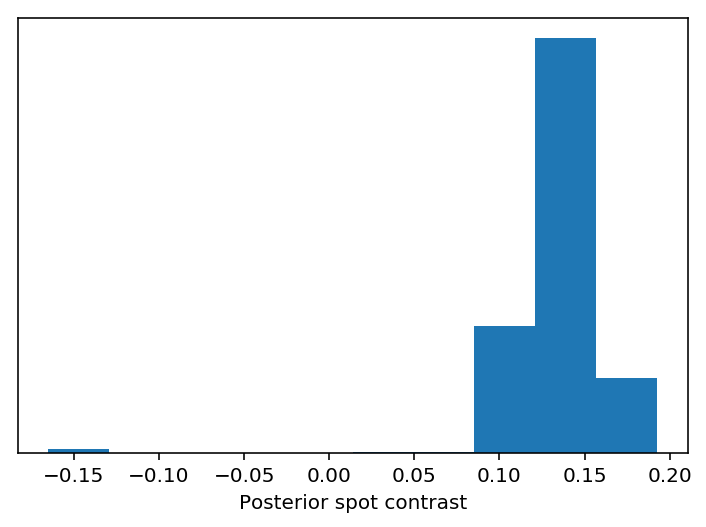

In [227]:
posterior_samples = np.loadtxt('trappist1_spotmodel_posteriors_bright.txt')
median_contrast = np.median(posterior_samples[:, -2])
plt.hist(posterior_samples[:, -2])
plt.xlabel('Posterior spot contrast')
plt.yticks([])

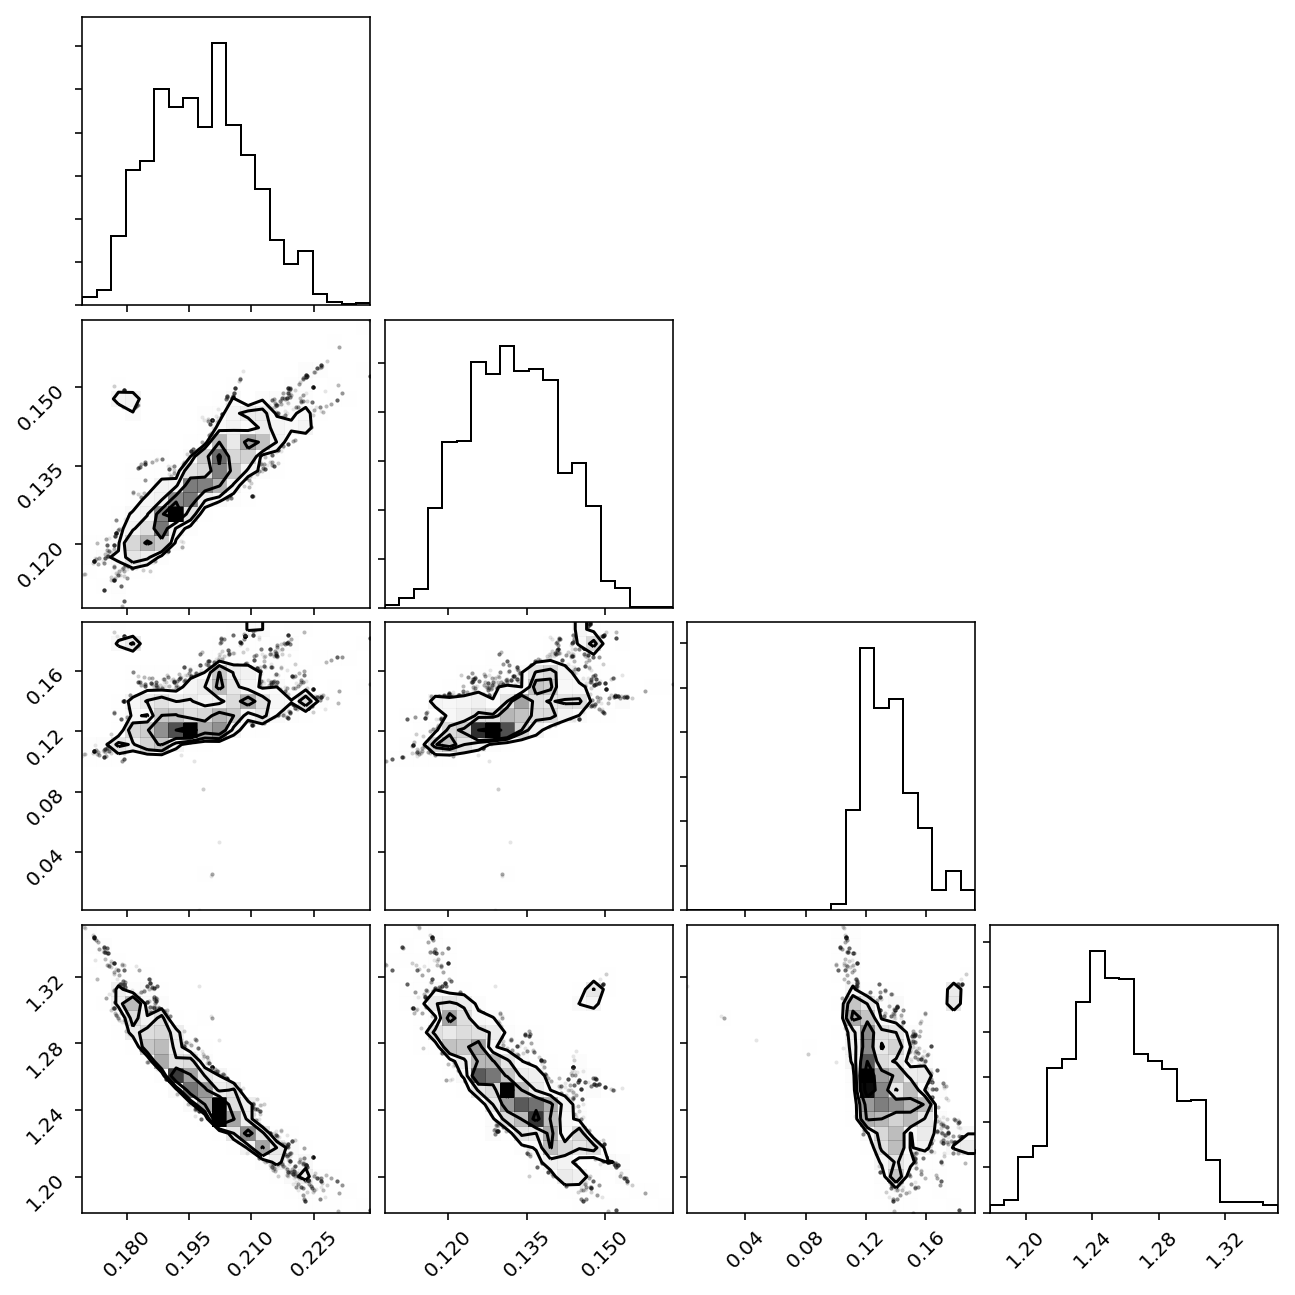

In [221]:
from corner import corner 

valid = posterior_samples[:, -2] > 0
fig = corner(np.hstack([posterior_samples[valid, 2::3], posterior_samples[valid, -1][:, np.newaxis]]))
ax = fig.get_axes()

In [180]:
from scipy.optimize import fmin_slsqp, fmin_tnc

def kepler_to_spitzer_contrast(kepler_contrast):
    sample_temperatures = 2559*u.K + np.arange(0, 200, 0.5)[:, np.newaxis]*u.K

    # Start with low-res in Kepler bandpass
    bb_trial = blackbody_lambda(kplr_wavelength, sample_temperatures).value
    bb_2559 = blackbody_lambda(kplr_wavelength, 2559*u.K).value
    bb_2600 = blackbody_lambda(kplr_wavelength, 2600).value

    spectrum_interp = np.interp(kplr_wavelength, phoenix_wavelength, phoenix_flux, left=0, right=0)
    spot_trial_spectrum = spectrum_interp * bb_trial / bb_2559

    contrast = (np.trapz(spot_trial_spectrum * kplr_trans * kplr_wavelength, x=kplr_wavelength) / 
                np.trapz(spectrum_interp * kplr_trans * kplr_wavelength, x=kplr_wavelength))

    spot_temperature = sample_temperatures[np.argmin(np.abs(contrast - kepler_contrast))][0]

    # Switch to hi-res for spitzer
    bb_spot = blackbody_lambda(phoenix_wavelength, spot_temperature).value
    bb_2559 = blackbody_lambda(phoenix_wavelength, 2559).value
    bb_2600 = blackbody_lambda(phoenix_wavelength, 2600).value

    trappist_flux = phoenix_flux * bb_2559/bb_2600
    trappist_spot = trappist_flux * bb_spot/bb_2559

    trans_interp = np.interp(phoenix_wavelength, spitz2_wave/10, spitz2_trans, left=0, right=0)

    spitzer_contrast = (np.trapz(trappist_spot * trans_interp * phoenix_wavelength, x=phoenix_wavelength) / 
                        np.trapz(trappist_flux * trans_interp * phoenix_wavelength, x=phoenix_wavelength))

    return spitzer_contrast.value

In [181]:
kepler_to_spitzer_contrast(median_contrast)

1.0384809011682892

In [60]:
spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

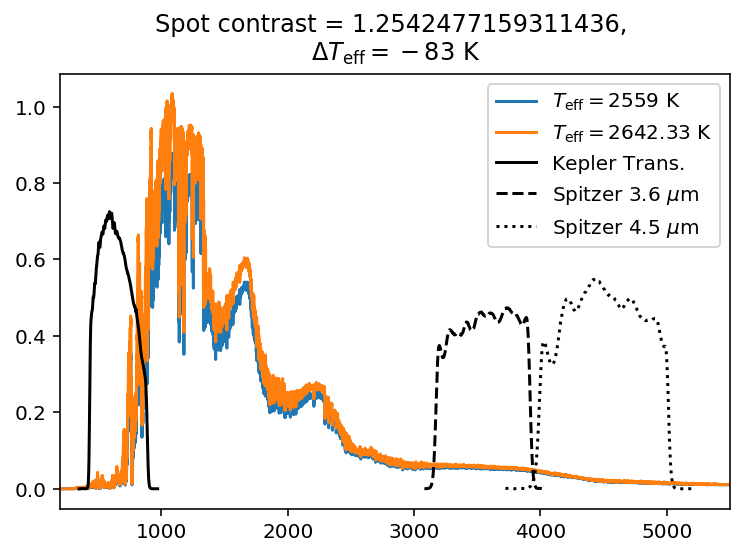

In [61]:
from scipy.ndimage import gaussian_filter1d

#plt.plot(phoenix_wavelength, phoenix_flux)

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)
bb_spot = blackbody_lambda(phoenix_wavelength, spot_temperature.value)

trappist_flux = phoenix_flux * bb_2559.value/bb_2600.value
plt.plot(phoenix_wavelength, gaussian_filter1d(trappist_flux, 100), 
         label='$T_\mathrm{eff} = 2559$ K')

trappist_spot = trappist_flux * bb_spot/bb_2559

plt.plot(phoenix_wavelength, gaussian_filter1d(trappist_spot, 100), 
         label='$T_\mathrm{{eff}} = {0:.2f}$ K'.format(spot_temperature.value))

plt.plot(kplr_wavelength, kplr_trans, color='k', label='Kepler Trans.')
plt.plot(spitz1_wave, spitz1_trans, color='k', ls='--', label='Spitzer 3.6 $\mu$m')
plt.plot(spitz2_wave, spitz2_trans, color='k', ls=':', label='Spitzer 4.5 $\mu$m')

plt.title('Spot contrast = {0}, \n$\Delta T_\mathrm{{eff}} = {1:.0f}$ K'
          .format(median_contrast, 2559 - spot_temperature.value))
plt.xlim([200, 5500])
plt.legend()
plt.show()

In [63]:
for spitz, channel in zip([[spitz1_wave, spitz1_trans], [spitz2_wave, spitz2_trans]], 
                          ['3.6 um', '4.5 um']):
    spitz_wave, spitz_trans = spitz
    trans_interp = np.interp(phoenix_wavelength, spitz_wave, spitz_trans, left=0, right=0)

    contrast = (np.trapz(trappist_spot * trans_interp * phoenix_wavelength, x=phoenix_wavelength) / 
                np.trapz(trappist_flux * trans_interp * phoenix_wavelength, x=phoenix_wavelength))
    
    print("{0}: c={1}".format(channel, contrast))

3.6 um: c=1.065366162833838
4.5 um: c=1.057862330367205


In [183]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')
spitzer_flux += -np.percentile(spitzer_flux, 0.1) + 1

spitzer_time += k2_time.min()

0.00677228382214


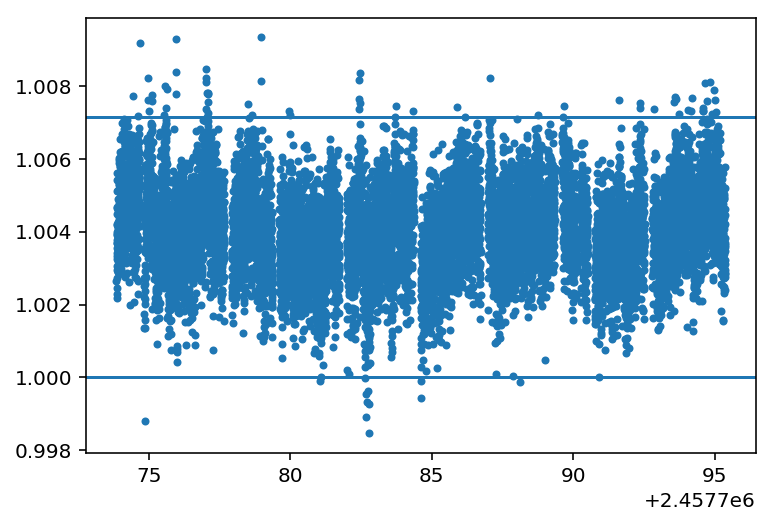

In [173]:
plt.plot(spitzer_time, spitzer_flux, '.')

max_flux = np.percentile(spitzer_flux, 99.5)
plt.axhline(1)
plt.axhline(max_flux)

covering_fraction = (max_flux - 1) / (1.057)
print(covering_fraction)

In [184]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 98)
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

In [185]:
# from libra import Star, Spot

# time = k2_time

# lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2 = posterior_samples[100, :-1]

# plt.errorbar(k2_time, k2_flux, k2_err, fmt='.', label='K2 Obs.')

# for contrast, lam in zip([1.25, 1.05], ["Kepler", "Spitzer 4.5 um"]):
#     spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=contrast), 
#              Spot.from_latlon(lat1, lon1, rad1, contrast=contrast), 
#              Spot.from_latlon(lat2, lon2, rad2, contrast=contrast)]

#     star = Star(spots=spots, rotation_period=3.3*u.day)
#     model_flux = star.flux(time)
#     model_flux /= np.max(model_flux)
    
#     plt.plot(time, model_flux, label='c={0} ({1})'
#              .format(contrast, lam))
#     print("{0} model rms: {1}".format(lam, np.std(model_flux)))
    
# spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=contrast), 
#          Spot.from_latlon(lat1, lon1, rad1, contrast=contrast), 
#          Spot.from_latlon(lat2, lon2, rad2, contrast=contrast)]

# star = Star(spots=spots, rotation_period=3.3*u.day)
# spitzer_model_flux = star.flux(spitzer_time) * 1.05 / 1.25
# spitzer_model_flux /= np.median(spitzer_model_flux)

# plt.plot(spitzer_time, spitzer_model_flux, label='manual')    

# plt.legend()
# plt.xlabel('Time [d]')
# plt.ylabel('Relative flux')
# plt.show()

<Container object of 3 artists>

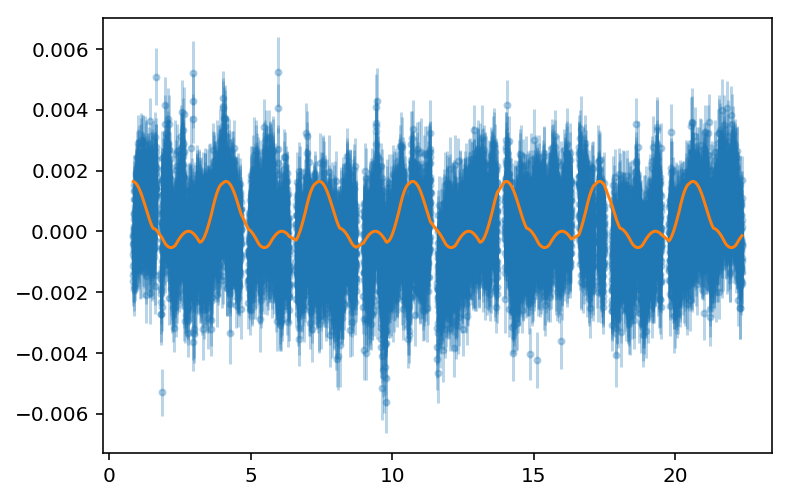

In [186]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.3)
plt.errorbar(spitzer_time, spitzer_model_flux - 1)

Finding optimal frequency:
 - Estimated peak width = 0.292
 - Using 5 steps per peak; omega_step = 0.0584
 - User-specified period range:  0.2 to 1.2
 - Computing periods at 450 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


0.52324388375111908

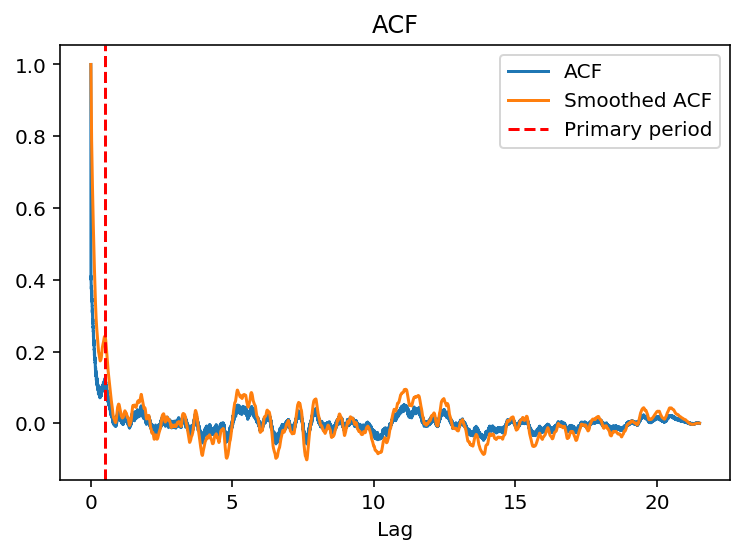

In [196]:
from interpacf import interpolated_acf, dominant_period

lag, acf = interpolated_acf(spitzer_time, spitzer_flux)
dominant_period(lag, acf, plot=True)

from gatspy import periodic

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.period_range = (0.2, 1.2)
model.fit(spitzer_time, spitzer_flux, spitzer_err);
model.best_period

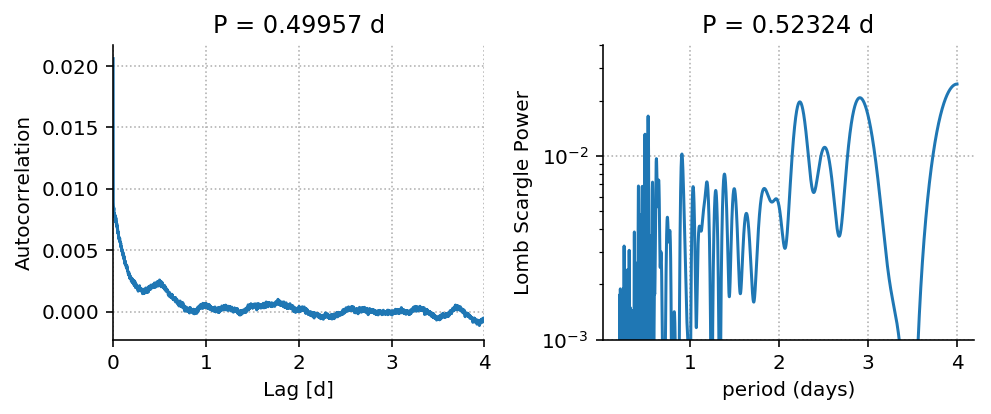

In [200]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
#ax[0].semilogy(lag, acf)
ax[0].plot(lag, acf)
ax[0].set_xlim([0, 4])
#ax[0].set_ylim([1e-5, 1e-2])
ax[0].set_xlabel('Lag [d]')
ax[0].set_ylabel('Autocorrelation')

lagrange = ((lag > 0.4) & (lag < 0.6))
peak_acf = lag[lagrange][np.argmax(acf[lagrange])]
ax[0].set_title("P = {0:.5f} d".format(peak_acf))

# Compute the scores on a grid of periods
periods = np.linspace(0.2, 4, 10000)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
ax[1].set_title("P = {0:.5f} d".format(model.best_period))
ax[1].semilogy(periods, scores)
ax[1].set(xlabel='period (days)', ylabel='Lomb Scargle Power', ylim=[1e-3, 4e-2])
          #xlim=(0.3, 1.2))
for axis in ax: 
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.grid(ls=':')
    
fig.tight_layout()
fig.savefig('quasiperiodic.pdf')